In [1]:
import warnings
warnings.simplefilter("ignore", FutureWarning)

In [2]:
from serial import Serial
from time import time, sleep

In [3]:
from scipy.integrate import odeint, ode
from scipy.signal import resample

In [4]:
from numpy import array, linspace, matrix, interp, sort, around
from numpy.random import normal
from numpy.linalg import pinv, eig

In [5]:
from control import tf, forced_response

In [6]:
%matplotlib inline
from matplotlib.pyplot import figure, style
from matplotlib import rcParams

style.use("seaborn")
params = {'text.latex.preamble' : r"\usepackage{cmbright}",
          'text.usetex' : True,
          'font.family' : 'sans-serif',
          'font.sans-serif' : ['Noto Sans'],
          'font.size' : 20}
rcParams.update(params)

In [7]:
def filtro_primer_orden(estado, t, entrada, a):
    '''
    Esta función se utiliza para filtrar una señal compleja, posiblemente no derivable,
    y obtener una señal mas amable con un servomecanismo fisico. Es un filtro de primer
    orden el cual toma como entrada el estado del sistema, el tiempo de simulación,
    el nombre de la señal de entrada y una ganancia a asociada al filtro, y da como 
    resultado la señal filtrada en el tiempo dado.
    '''
    y = estado
    u = entrada(estado, t)
    salida = a*u - a*y
    return salida

def ruido(t0, tf, h, μ, σ):
    '''
    Esta función toma los valores para el tiempo inicial, tiempo final, periodo de
    integración h, media aritmética de los datos μ y desviación estandar σ, y da
    como resultado una señal, empezando y finalizando en los tiempos dados, y con
    una distancia temporal de acuerdo al tiempo de integración, de manera aleatoria,
    de acuerdo a una distribución normal, la cual ha sido tratada para que sea
    adecuada para la identificación de parametros de un servomecanismo.
    '''
    from numpy.random import normal
    from numpy import linspace
    from scipy.signal import resample
    
    t = h*10
    n = int(1/t)
    ruido = normal(μ, σ, n)
    ts = linspace(t0, tf, n)

    ruido, ts = resample(x=ruido, num=n*10+1, t=ts)
    
    return ts, ruido

def alimentador(x, t, ts, xs):
    '''
    Esta función toma un vector con el estado del sistema, el tiempo de simulación,
    y un par de arreglos con un conjunto de datos, y da como resultado el valor de
    la señal descrita en el segundo arreglo, en el tiempo dado por el tiempo de
    simulación. Este valor se calcula por medio de una interpolación.
    '''
    from numpy import interp
    salida = interp(t, ts, xs)
    return salida

In [8]:
def referencias(t):
    from numpy import interp
    if t >= ret:
        return interp(t - ret, tr, s2)
    else:
        return 0

def alg_control_real(xs, ts):
    p_sat = 255
    e = referencias(ts[-1]) - xs[-1]
    ep = (xs[-1] - xs[-2])/(ts[-1] - ts[-2])
    u = kp*e - kd*ep
    return int(max(min(p_sat,u),-p_sat))

def alg_control_sim(xs, t):
    p_sat = 255
    e = referencias(t) - xs[0]
    ep = - xs[1]
    u = kp*e - kd*ep
    return int(max(min(p_sat,u),-p_sat))

def motor_cd(t, x):
    '''
    Esta función toma un vector con el estado del sistema, el tiempo de simulación, 
    y nombre de función de entrada, y da como resultado la derivada del sistema,
    calculada a partir de la dinámica simplificada de un motor de corriente directa y de
    la señal de entrada del motor.
    '''
    y, ẏ = x
    u = alg_control_sim(x, t)
    ÿ = b*u - a*ẏ
    return [ẏ, ÿ]

In [9]:
ttexp = 10
kp, kd = 6, 0
ret = 3

tr, ss = ruido(0, ttexp, 0.001, 127, 50)
x0 = [0, 0]
s1 = lambda x, t: alimentador(x, t, tr, ss)
datos = odeint(filtro_primer_orden, x0, tr, args=(s1, 20))
s2, _ = array(datos).T

In [10]:
xs = [0]
us = [0]
ts = [0]

with Serial("/dev/cu.usbserial-A603QGMH", baudrate=2000000) as puerto_arduino:
    while ts[-1] < ttexp + ret:
        try:
            lec = int.from_bytes(puerto_arduino.read(6), byteorder='little')
            xs.append(int(lec/(2**32))/4)
            ts.append(int(lec%(2**32))*0.000001)
        except KeyboardInterrupt:
            break
        
        if len(xs) > 1:
            us.append(alg_control_real(xs[-2:], ts[-2:]))
        else:
            us.append(0)
            
        if us[-1] > 0:
            puerto_arduino.write(bytes([0, us[-1]]))
        else:
            puerto_arduino.write(bytes([1, abs(us[-1])]))
            
    puerto_arduino.write(bytes([0, 0]))

In [11]:
t_exp = []
q_exp = []
u_exp = []
for i, t in enumerate(ts):
    if t >= ret:
        t_exp.append(ts[i])
        q_exp.append(xs[i])
        u_exp.append(us[i])
        
t_exp = array(t_exp)
q_exp = array(q_exp)
u_exp = array(u_exp)

In [12]:
t_interp = linspace(ret, ttexp + ret, len(ts))
q_interp = array([interp(t, t_exp, q_exp) for t in t_interp])
u_interp = array([interp(t, t_exp, u_exp) for t in t_interp])

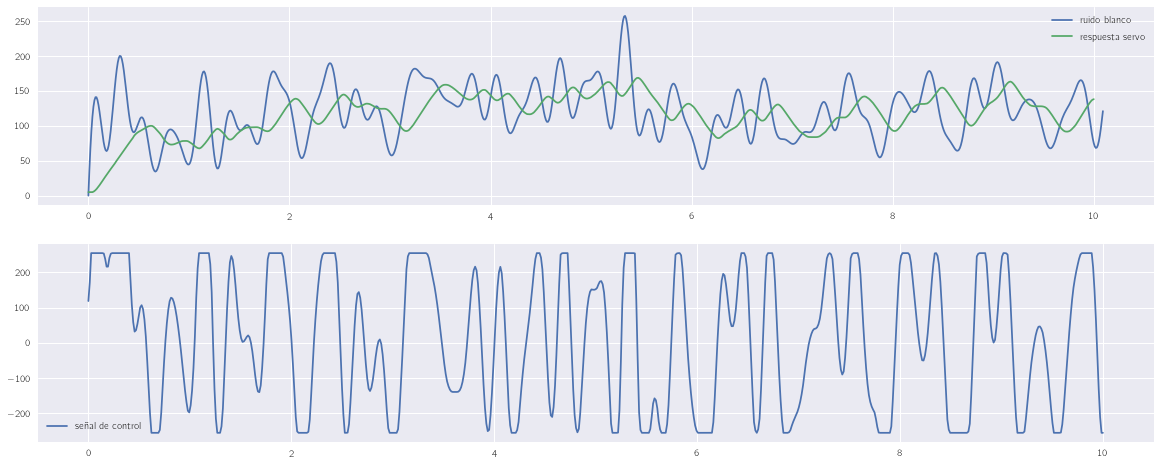

In [13]:
fig = figure(figsize=(20,8))
ax1, ax2 = fig.subplots(2,1)
p1, = ax1.plot(tr, s2)
p2, = ax1.plot(t_interp - ret, q_interp)
p3, = ax2.plot(t_interp - ret, u_interp)
ax1.legend([p1, p2], ["ruido blanco", "respuesta servo"])
ax2.legend([p3], ["señal de control"]);

In [14]:
fso2 = tf([400, 0, 0], [1, 40, 400])
fso1 = tf([-400, 0], [1, 40, 400])
fso0 = tf([400], [1, 40, 400])

In [15]:
_,  B, _ = forced_response(fso2, t_interp, q_interp)
_, A1, _ = forced_response(fso1, t_interp, q_interp)
_, A2, _ = forced_response(fso0, t_interp, u_interp)

In [16]:
A = matrix([A1, A2]).T
B = matrix(B).T

In [17]:
θ = pinv(A)*B
θ

matrix([[11.95872562],
        [13.8443177 ]])

In [18]:
λs, E = eig(A.T*A)
λmax, λmin = max(λs), min(λs)
κ = λmax/λmin
κ

7.406333968234603

In [21]:
a, b = θ.T.tolist()[0]

In [22]:
sis = ode(motor_cd)
sis.set_initial_value([0, 0])
sis.set_integrator('vode', nsteps=5000, method="bdf");

In [23]:
t_sim = linspace(0, ttexp + ret, len(ts))
y_sim = [sis.integrate(t) for t in t_sim[1:]]
y_sim.insert(0, [0, 0])

In [24]:
t_simu = []
y_simu = []
for i, t in enumerate(t_sim):
    if t >= ret:
        t_simu.append(t_sim[i])
        y_simu.append(y_sim[i])

In [25]:
ts = linspace(ret, ttexp + ret, len(ts))
y_simulacion = [interp(t, t_simu, array(y_simu).T[0]) for t in ts]
y_real = [interp(t, t_interp, q_interp) for t in ts]
referencia = [interp(t, tr + ret, s2) for t in ts]

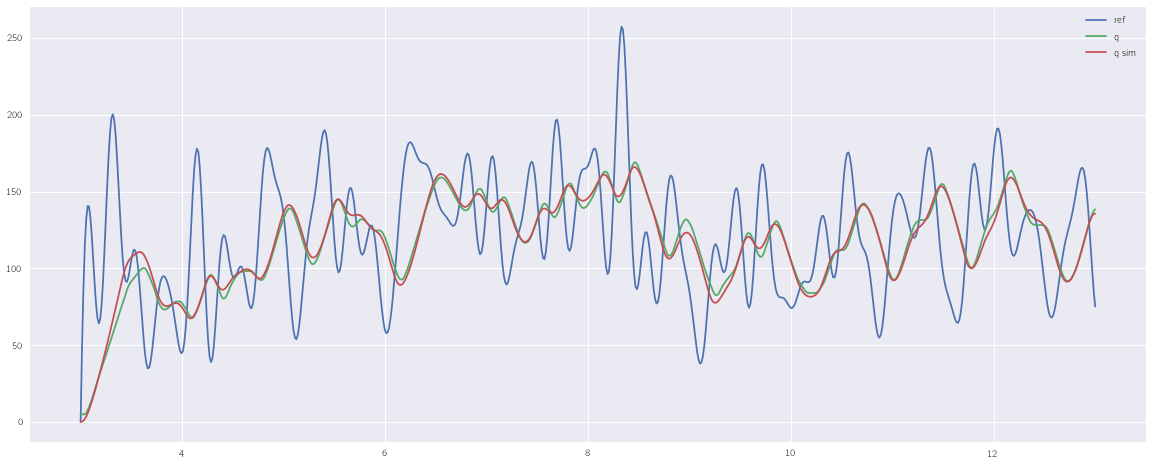

In [26]:
fig = figure(figsize=(20,8))
ax = fig.gca()
p1, = ax.plot(ts, referencia)
p2, = ax.plot(ts, y_real)
p3, = ax.plot(ts, y_simulacion)
ax.legend([p1, p2, p3], ["ref", "q", "q sim"]);

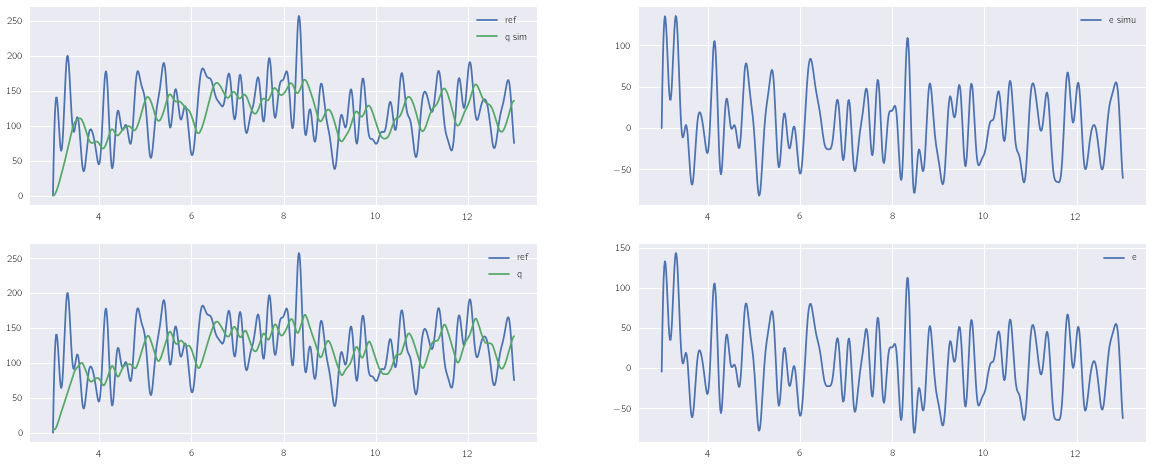

In [27]:
fig = figure(figsize=(20,8))
[ax1, ax2], [ax3, ax4] = fig.subplots(2, 2)
p0, = ax1.plot(ts, referencia)
p1, = ax1.plot(ts, y_simulacion)
p2, = ax3.plot(ts, referencia)
p3, = ax3.plot(ts, y_real)
p4, = ax2.plot(ts, array(referencia) - array(y_simulacion))
p5, = ax4.plot(ts, array(referencia) - array(y_real))
ax1.legend([p0, p1], ["ref", "q sim"])
ax3.legend([p2, p3], ["ref", "q"])
ax2.legend([p4], ["e simu"])
ax4.legend([p5], ["e"]);

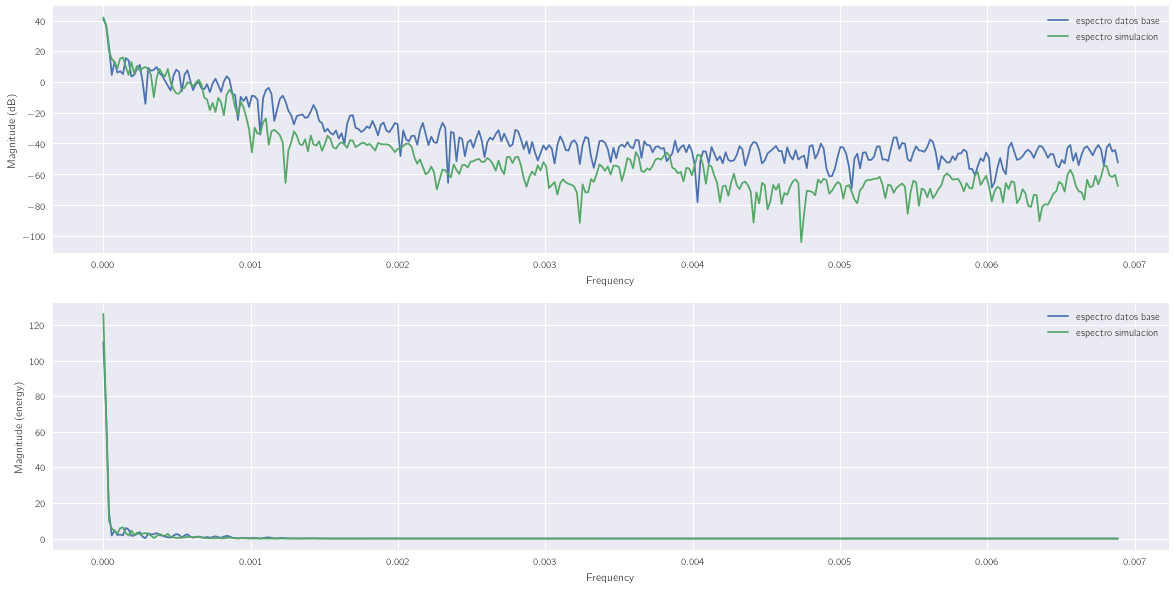

In [28]:
fig = figure(figsize=(20,10))
ax1, ax2 = fig.subplots(2,1)
_, _, p1 = ax1.magnitude_spectrum(xs, Fs=ttexp/len(xs), scale='dB')
_, _, p2 = ax1.magnitude_spectrum(y_simulacion, Fs=ttexp/len(y_simulacion), scale='dB')
_, _, p3 = ax2.magnitude_spectrum(xs, Fs=ttexp/len(xs))
_, _, p4 = ax2.magnitude_spectrum(y_simulacion, Fs=ttexp/len(y_simulacion))
ax1.legend([p1, p2], ["espectro datos base", "espectro simulacion"])
ax2.legend([p3, p4], ["espectro datos base", "espectro simulacion"]);